## Xray Lung Classifier
Github Repository: https://github.com/patelshehbaz/Xray-Lung-Classifier-PyTorch

The project aims to use deep learning techniques, specifically CNNs, to differentiate between normal and pneumonia-affected lung X-ray images.  This project addresses the need for an automated system to provide fast and reliable classification of chest X-ray images.

The project employs a ResNet34 model pre-trained on ImageNet as the foundation. It is fine-tuned with a dataset comprising normal and pneumonia chest X-ray images. The model undergoes training, validation, and testing phases.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet50

In [3]:
!ls "/content/drive/My Drive/"

 Chest-CT-Scan-data.zip
 chest_xray
 chest_xray.zip
'Colab Notebooks'
'Hardware acceleration for computer intelligence.docx'
'Hardware accelerator for Neural network.docx'
 Portfolio.gsite
 Shehbaz-Patel.gdoc
'Tracking of Humans in Industrial Environments.docx'


In [4]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
#!unzip "/content/drive/My Drive/chest_xray.zip" -d "/content/drive/My Drive/chest_xray"

In [5]:
cd /content/drive/MyDrive/chest_xray/

/content/drive/MyDrive/chest_xray


In [6]:
train_normal = glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA/*")

Above we create lists of file paths for chest X-ray images, organizing them by training, testing sets, and further by normal and pneumonia classifications. It searches through specified directories within the Google Drive, collecting paths to all images within those directories.

In [7]:
print("Number of train samples in Normal category {}".format(len(train_normal)))
print("Number of train samples in Pneumonia category {}".format(len(train_pneumonia )))
print("Number of test samples in Normal category {}".format(len(test_normal)))
print("Number of test samples in Pneumonia category {}".format(len(test_pneumonia)))

Number of train samples in Normal category 1341
Number of train samples in Pneumonia category 3875
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


In [8]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

above we combines the paths for normal and pneumonia images into single lists for training, testing. This organization simplifies further processing, such as loading the images and labels for model training and evaluation.

In [9]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

Above we creates label lists for the training, testing datasets, where 0 represents the "Normal" class and 1 represents the "Pneumonia" class. The lengths of the label lists correspond to the numbers of images in each category, ensuring each image has an associated label.

In [10]:
print(f'Number of train paths and train labels: {len(train_paths),len(train_labels)}')
print(f'Number of test path and test labels: {len(test_paths),len(test_labels)}')

Number of train paths and train labels: (5216, 5216)
Number of test path and test labels: (624, 624)


In [11]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, stratify=train_labels)

 Above we split the training dataset into a smaller training set and a validation set. This operation respects the stratification of labels, ensuring that the proportion of classes (Normal and Pneumonia) is consistent across the new training and validation sets.

In [12]:
def show_random_images():
  path_random_normal = random.choice(train_normal)
  path_random_abnormal = random.choice(train_pneumonia)

  fig = plt.figure(figsize=(10,10))

  ax1 = plt.subplot(1, 2, 1)
  ax1.imshow(Image.open(path_random_normal).convert("LA"))
  ax1.set_title("Normal X-ray")

  ax1 = plt.subplot(1, 2, 2)
  ax1.imshow(Image.open(path_random_abnormal).convert("LA"))
  ax1.set_title("Abnormal X-ray")


above function show_random_images, visualizes one random image each from the "Normal" and "Pneumonia" categories of the training dataset

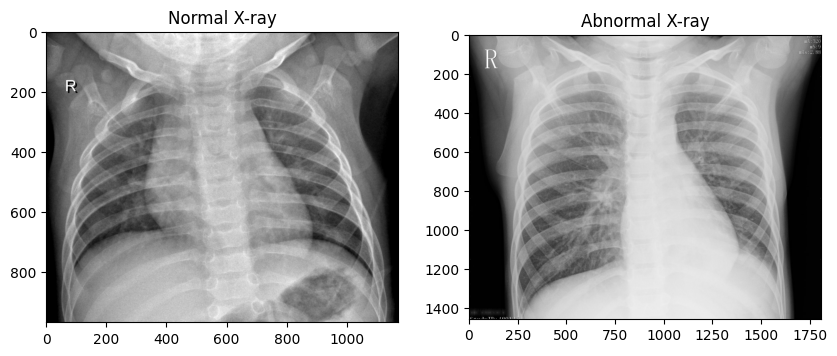

In [ ]:
show_random_images()

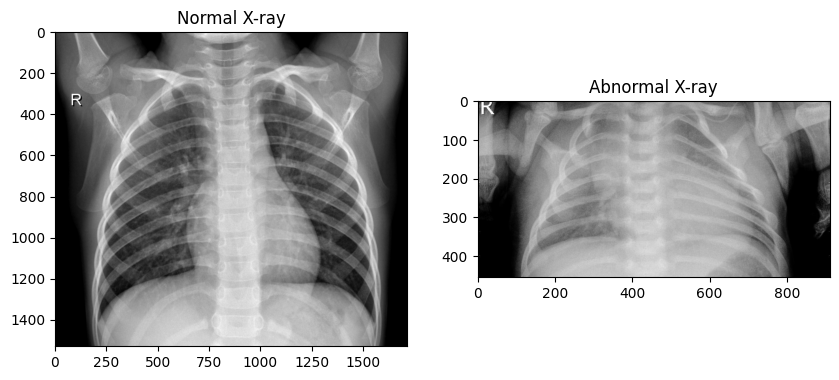

In [ ]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
  def __init__(self, paths, labels, transform=None):

    self.paths = paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self,index):
    path = self.paths[index]
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    label = self.labels[index]
    label = torch.tensor([label])

    return image, label

XrayDataset class facilitates the loading and preprocessing of chest X-ray images for training models.



In [ ]:
resnet = resnet34()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaNet(nn.Module):
  def __init__(self, pretrained=True):
    super(PneumoniaNet, self).__init__()
    self.backbone = resnet34(pretrained=pretrained)
    self.dropout = nn.Dropout(p=0.3)
    self.fc = nn.Linear(in_features=512, out_features=1)


  def forward(self,x):
    x = self.backbone.conv1(x)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.backbone.layer4(x)

    x = self.backbone.avgpool(x)

    x = x.view(x.size(0),-1)
    x = self.dropout(x)
    x = self.fc(x)

    return x

above we created a custom neural network class named PneumoniaNet. It utilizes a pre-trained ResNet-34 model  as its base, adding a dropout layer for regularization  and a fully connected layer to output the prediction.

In [ ]:
image_size = (500,500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(train_paths, train_labels, test_transform)

 Above we did transformations for training and testing datasets using transforms module, aiming to augment and standardize the input images.
* ToTensor(): Converts image to PyTorch tensor with values in [0, 1].
* RandomRotation(): Randomly rotates the image by up to 15 degrees.
* RandomHorizontalFlip(): Randomly flips the image horizontally.
* RandomResizedCrop(): Randomly crops the image to  the specified size within the given scale range.
* Normalize(): Normalizes the image with the provided mean and standard deviation per channel.
* Resize(): Resizes the image to the specified size.

In [ ]:
pretrained = True
model = PneumoniaNet(pretrained=pretrained)
num_epochs = 10
train_batch_size = 16
valid_batch_size = 16
lr = 3e-3

train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_sizes = {
    "train" : len(train_dataset),
    "val" : len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

Above we set the model training environment, specifies training parameters such as the number of epochs, batch size, and learning rate, and creates DataLoader instances for both training and validation datasets to efficiently batch and shuffle the data.

In [ ]:
model.cuda()

In [ ]:
! nvidia-smi

Mon Apr  1 05:47:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              28W /  70W |    383MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists to save epoch metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)


    return model, train_losses, val_losses, train_accs, val_accs


above we created a function to train and validate the model across specified epochs. It alternates between training and validation phases, applies gradient updates during training, and evaluates performance. It keeps track of performance metrics (loss and accuracy) and updates the model weights to those achieving the best validation accuracy.

In [ ]:
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------
train Loss: 0.3095 Acc: 0.8691
val Loss: 11.0507 Acc: 0.3354

Epoch 2/10
----------
train Loss: 0.2458 Acc: 0.9054
val Loss: 0.2225 Acc: 0.9205

Epoch 3/10
----------
train Loss: 0.2261 Acc: 0.9139
val Loss: 0.2824 Acc: 0.9118

Epoch 4/10
----------
train Loss: 0.2171 Acc: 0.9121
val Loss: 0.6534 Acc: 0.7546

Epoch 5/10
----------
train Loss: 0.2125 Acc: 0.9185
val Loss: 0.1934 Acc: 0.9213

Epoch 6/10
----------
train Loss: 0.1861 Acc: 0.9269
val Loss: 0.2409 Acc: 0.9149

Epoch 7/10
----------
train Loss: 0.1850 Acc: 0.9325
val Loss: 0.1923 Acc: 0.9236

Epoch 8/10
----------
train Loss: 0.1795 Acc: 0.9279
val Loss: 1.1600 Acc: 0.7653

Epoch 9/10
----------
train Loss: 0.1715 Acc: 0.9284
val Loss: 0.7651 Acc: 0.7234

Epoch 10/10
----------
train Loss: 0.1573 Acc: 0.9445
val Loss: 0.2568 Acc: 0.8970

Training complete in 92m 23s
Best val Acc: 0.923569


* Training Loss and Accuracy: the training loss decreases and accuracy increases over epochs, indicating the model is learning and improving on the training dataset.
* Validation Loss and Accuracy: There are some fluctuations in validation loss and accuracy across epochs, with significant improvements . The highest validation accuracy achieved is around 92.36% in epoch 7, which is captured as the best model performance.
*  The training process took approximately 92 minutes, indicating a substantial computational effort

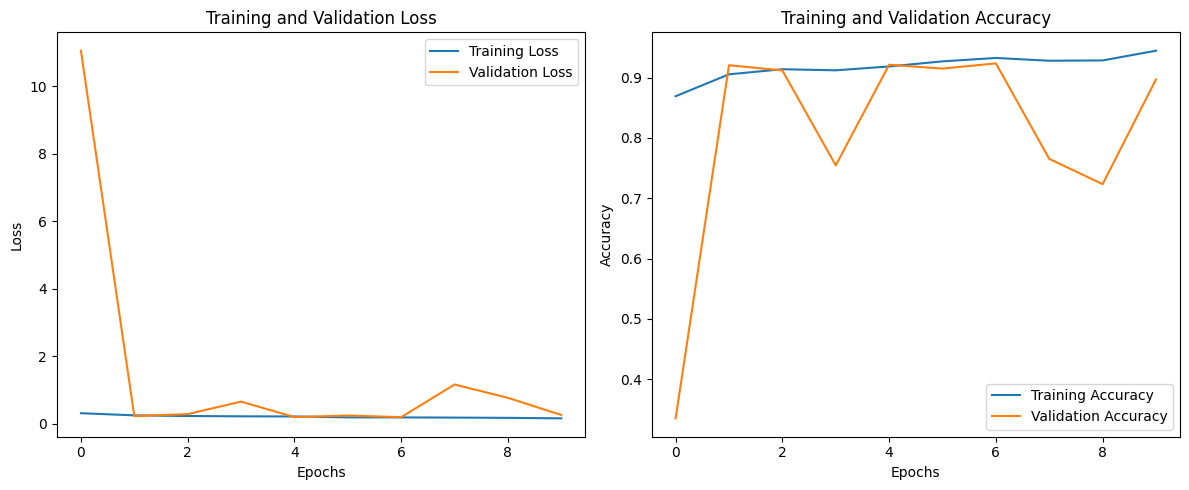

In [ ]:
# Plotting
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [ ]:
test_paths = glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL/*") + glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL/*")) + [1] * len(glob.glob("/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA/*"))

above we gathers the file paths and labels for the test dataset from the Normal and Pneumonia directories. It assigns label 0 to all normal X-rays and label 1 to all pneumonia X-rays, preparing the test data for evaluation.

In [ ]:
len(test_paths), len(test_labels)

(624, 624)

In [ ]:
test_dataset = XrayDataset(test_paths,test_labels,test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

drop_last set to false to include all test samples.

In [ ]:
y_true=[]
y_pred=[]

for i, (tensor,labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
  with torch.no_grad():
    predictions = model(tensor.cuda())
    predictions = predictions.sigmoid()
    predictions = predictions > 0.5
    y_pred.append(predictions)
    y_true.append(labels)



  0%|          | 0/20 [00:00<?, ?it/s]

* Iterates over the test_dataloader to make predictions with the trained model, storing the ground truth labels and the model's predictions in y_true and y_pred, respectively.
* The model's outputs are passed through a sigmoid function and a threshold of 0.5 to obtain binary predictions.

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

Concatenates all the batches of predictions and true labels into two single tensors, y_pred and y_true, for easier evaluation of the model's performance on the test set.

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

Converts the y_pred and y_true arrays to int64 data type, ensuring that they are in the proper format for computing classification metrics, which typically expect integer labels

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
accuracy_score(y_true,y_pred)

0.8733974358974359

the test accuracy is relatively high, suggesting the model has learned meaningful patterns from the data that are applicable to the broader distribution of similar images.

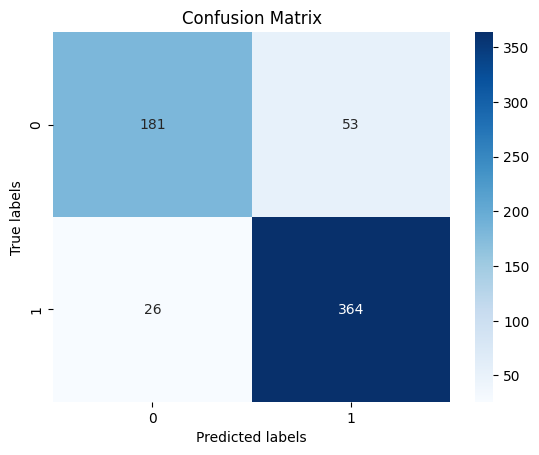

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

* True Positives (TP): The bottom right cell (364) shows the true positives, indicating the number of pneumonia cases correctly identified by the model.
* True Negatives (TN): The top left cell (181) shows the true negatives, indicating the number of normal cases correctly identified by the model.
* False Positives (FP): The top right cell (53) shows the false positives, where the model incorrectly identified normal cases as pneumonia.
* False Negatives (FN): The bottom left cell (26) shows the false negatives, where the model incorrectly identified pneumonia cases as normal.

In [ ]:
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Recall of the model is 0.93
Precision of the model is 0.87
F1 Score of the model is 0.90


* Recall of 0.93: This indicates that the model is very good at identifying the positive cases for pneumonia. It suggests that out of all actual pneumonia cases, the model correctly identifies 93% of them.
* Precision of 0.87: This means that when the model predicts pneumonia, it is correct about 87% of the time. This is also a strong result, though slightly lower than the recall, indicating that there are some false positives.
* F1 Score of 0.90: The F1 Score is a harmonic mean of precision and recall, and a high value shows that the model has a good balance between the two. An F1 Score of 0.90 is very good and indicates a robust model.

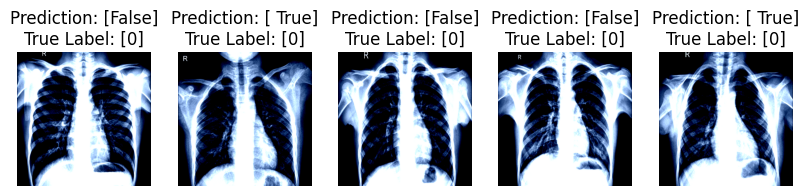

In [ ]:
def plot_images_predictions(images, true_labels, predictions, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        plt.title(f'Prediction: {predictions[i]}\nTrue Label: {true_labels[i]}')
        plt.axis('off')
    plt.show()

# Select a small batch from your test dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to('cuda'), labels.to('cuda')
with torch.no_grad():
    preds = model(images)
    preds = preds.sigmoid() > 0.5

# Plotting the predictions against the actual labels
plot_images_predictions(images, labels.cpu().numpy(), preds.cpu().numpy())


* True indicates pneumonia and False indicates normal.
* 0 indicates normal and 1 indicates pneumonia.
